# DeepLabV3Plus
Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastai.learner import defaults, Learner

from pathlib import Path
import random

Descarga de la librería de arquitecturas.

In [ ]:
!wget https://www.dropbox.com/s/cmoblvx5icdifwl/architectures.zip?dl=1 -O architectures.zip
!unzip architectures.zip

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [5]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [6]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [8]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [10]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10)
                    ],p=1)

In [11]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [12]:
transforms2=Compose([],p=1)

In [13]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [14]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [15]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [16]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [17]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [18]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

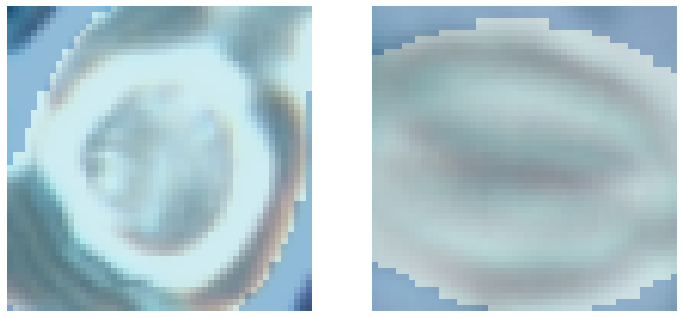

In [19]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Definición del modelo.

In [ ]:
from architectures import DeepLabV3Plus
model = DeepLabV3Plus(backbone_name="resnet50", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [22]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/DeepLabV3Plus"

Freeze y elección de la tasa de aprendizaje.

Recorder

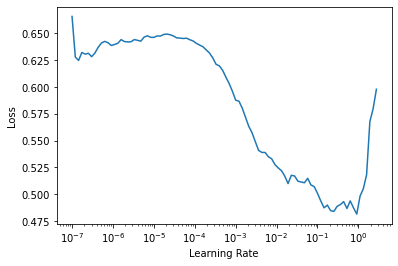

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.274402,0.396595,0.904407,0.825495,06:49
1,0.247707,0.340136,0.910153,0.835120,06:47
2,0.215331,0.349536,0.902871,0.822940,06:46
3,0.217509,0.328139,0.904383,0.825455,06:44
4,0.212694,0.247289,0.934968,0.877879,06:45
5,0.196442,0.221974,0.942013,0.890383,06:44
6,0.189435,0.189857,0.952013,0.908420,06:50
7,0.195292,0.204461,0.949486,0.903830,06:59
8,0.190728,0.185741,0.952471,0.909254,06:57
9,0.179524,0.178278,0.953922,0.911904,06:59


Better model found at epoch 0 with valid_loss value: 0.3965947926044464.


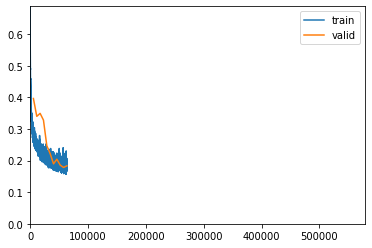

Better model found at epoch 1 with valid_loss value: 0.3401360511779785.
Better model found at epoch 3 with valid_loss value: 0.3281387984752655.
Better model found at epoch 4 with valid_loss value: 0.2472887635231018.
Better model found at epoch 5 with valid_loss value: 0.22197355329990387.
Better model found at epoch 6 with valid_loss value: 0.1898573487997055.
Better model found at epoch 8 with valid_loss value: 0.1857413947582245.
Better model found at epoch 9 with valid_loss value: 0.1782783567905426.
No improvement since epoch 9: early stopping


In [ ]:
name = "model_DeepLabV3Plus_resnet50_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1782783567905426,0.9539224128496103,0.9119040734331968]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

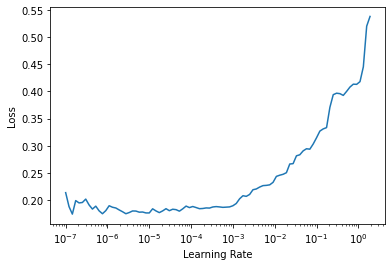

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.182503,0.171924,0.955672,0.915106,06:53
1,0.170862,0.172881,0.955560,0.914901,06:48
2,0.173342,0.177391,0.955040,0.913948,06:50


Better model found at epoch 0 with valid_loss value: 0.17192362248897552.


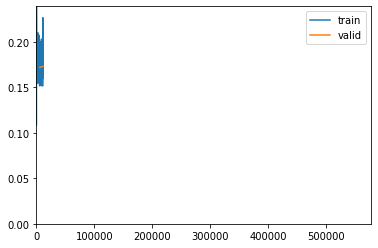

No improvement since epoch 0: early stopping


In [ ]:
name = "model_DeepLabV3Plus_resnet50_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17192362248897552,0.9556715480963361,0.9151063023843518]



---


Definición del modelo.

In [23]:
del model, learn
model = DeepLabV3Plus(backbone_name="resnet50", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [24]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/DeepLabV3Plus"

Freeze y elección de la tasa de aprendizaje.

Recorder

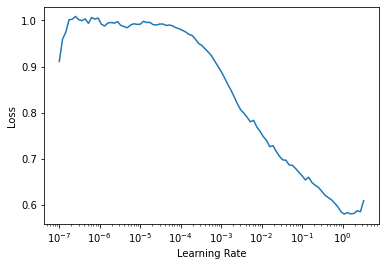

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.277548,0.871689,0.830737,0.710479,06:53
1,0.251256,0.427650,0.893308,0.807188,06:56
2,0.241132,0.420772,0.882469,0.789659,06:51
3,0.236860,0.265738,0.932389,0.873341,06:53
4,0.205667,0.237495,0.937449,0.882263,06:57
5,0.207063,0.219739,0.945339,0.896344,06:46
6,0.179396,0.191250,0.951184,0.906912,06:51
7,0.178868,0.187749,0.951917,0.908245,06:51
8,0.171873,0.177220,0.954189,0.912392,06:52
9,0.205779,0.187782,0.951550,0.907578,06:52


Better model found at epoch 0 with valid_loss value: 0.871688723564148.


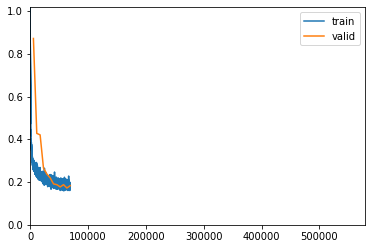

Better model found at epoch 1 with valid_loss value: 0.42765042185783386.
Better model found at epoch 2 with valid_loss value: 0.420771986246109.
Better model found at epoch 3 with valid_loss value: 0.2657383680343628.
Better model found at epoch 4 with valid_loss value: 0.23749510943889618.
Better model found at epoch 5 with valid_loss value: 0.2197393923997879.
Better model found at epoch 6 with valid_loss value: 0.19124995172023773.
Better model found at epoch 7 with valid_loss value: 0.18774864077568054.
Better model found at epoch 8 with valid_loss value: 0.1772201508283615.
Better model found at epoch 10 with valid_loss value: 0.17203019559383392.
No improvement since epoch 10: early stopping


In [ ]:
name = "model_DeepLabV3Plus_resnet50_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17203019559383392,0.955259639459168,0.9143512355210033]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

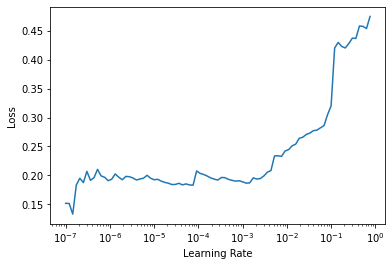

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.161601,0.171803,0.955568,0.914917,06:51
1,0.164741,0.171352,0.955482,0.914758,06:58
2,0.167430,0.178213,0.953029,0.910272,06:54
3,0.168198,0.171075,0.955883,0.915494,06:56
4,0.170178,0.169505,0.955997,0.915704,06:56
5,0.159267,0.173440,0.955410,0.914627,06:58
6,0.160987,0.181492,0.954133,0.912290,06:46


Better model found at epoch 0 with valid_loss value: 0.17180295288562775.


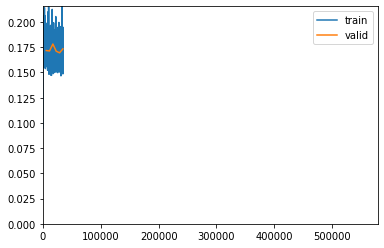

Better model found at epoch 1 with valid_loss value: 0.17135180532932281.
Better model found at epoch 3 with valid_loss value: 0.17107529938220978.
Better model found at epoch 4 with valid_loss value: 0.169504776597023.
No improvement since epoch 4: early stopping


In [ ]:
name = "model_DeepLabV3Plus_resnet50_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.16300860047340393,0.9571062252852485,0.9177408557712723]

# Modelos sin aumento de datos
Definición del modelo.

In [ ]:
del model, learn
model = DeepLabV3Plus(backbone_name="resnet50", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/DeepLabV3Plus"

Freeze y elección de la tasa de aprendizaje.

Recorder

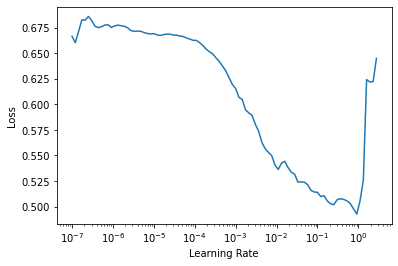

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.286608,0.414387,0.912779,0.839552,06:44
1,0.243675,0.359296,0.921866,0.855056,06:36
2,0.225138,0.304151,0.927847,0.865405,06:29
3,0.207880,0.277287,0.927123,0.864147,06:31
4,0.193214,0.254882,0.934692,0.877391,06:31
5,0.177813,0.227446,0.940930,0.888450,06:29
6,0.196230,0.195990,0.950117,0.904974,06:31
7,0.196477,0.187959,0.951714,0.907876,06:32
8,0.204769,0.184610,0.952904,0.910044,06:33
9,0.184885,0.179411,0.954154,0.912327,06:39


Better model found at epoch 0 with valid_loss value: 0.4143873453140259.


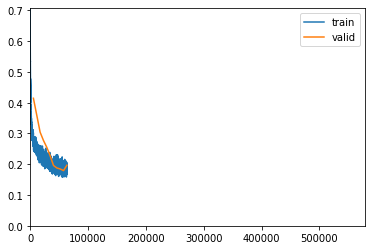

Better model found at epoch 1 with valid_loss value: 0.359296053647995.
Better model found at epoch 2 with valid_loss value: 0.30415108799934387.
Better model found at epoch 3 with valid_loss value: 0.27728667855262756.
Better model found at epoch 4 with valid_loss value: 0.25488218665122986.
Better model found at epoch 5 with valid_loss value: 0.2274455428123474.
Better model found at epoch 6 with valid_loss value: 0.19598983228206635.
Better model found at epoch 7 with valid_loss value: 0.18795932829380035.
Better model found at epoch 8 with valid_loss value: 0.18460971117019653.
Better model found at epoch 9 with valid_loss value: 0.17941100895404816.
No improvement since epoch 9: early stopping


In [ ]:
name = "model_DeepLabV3Plus_resnet50_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17941100895404816,0.954153880452173,0.9123272177600111]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

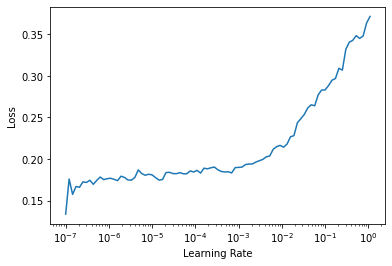

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.167711,0.181335,0.953502,0.911137,06:34
1,0.186574,0.180754,0.953824,0.911725,06:31
2,0.170743,0.190272,0.952800,0.909856,06:30
3,0.154986,0.192362,0.952035,0.908461,06:27


Better model found at epoch 0 with valid_loss value: 0.18133454024791718.


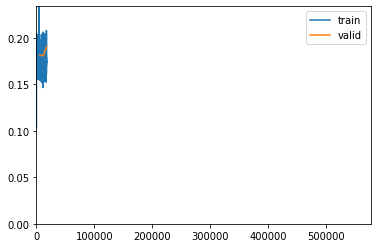

Better model found at epoch 1 with valid_loss value: 0.18075422942638397.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_DeepLabV3Plus_resnet50_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.18075422942638397,0.9538244489668068,0.9117250427280764]



---


Definición del modelo.

In [ ]:
del model, learn
model = DeepLabV3Plus(backbone_name="resnet50", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/DeepLabV3Plus"

Freeze y elección de la tasa de aprendizaje.

Recorder

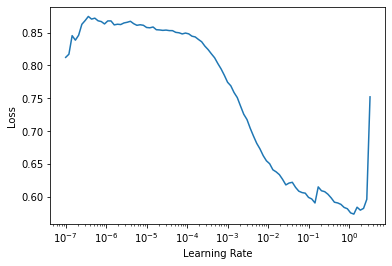

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.292803,0.527061,0.875161,0.778032,06:34
1,0.250682,0.380749,0.905812,0.827839,06:28
2,0.222082,0.409644,0.888839,0.799920,06:27
3,0.221685,0.356378,0.898225,0.815252,06:30
4,0.221234,0.266856,0.928261,0.866126,06:31
5,0.213361,0.224206,0.942232,0.890774,06:35
6,0.180409,0.206490,0.947009,0.899352,06:35
7,0.189706,0.197793,0.949116,0.903160,06:35
8,0.192960,0.186856,0.952656,0.909592,06:33
9,0.184347,0.187137,0.952028,0.908448,06:50


Better model found at epoch 0 with valid_loss value: 0.5270609855651855.


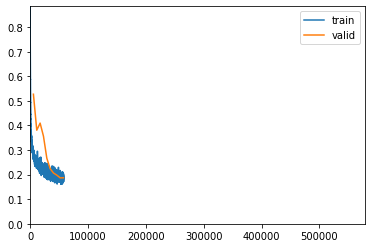

Better model found at epoch 1 with valid_loss value: 0.3807491362094879.
Better model found at epoch 3 with valid_loss value: 0.35637786984443665.
Better model found at epoch 4 with valid_loss value: 0.26685628294944763.
Better model found at epoch 5 with valid_loss value: 0.2242061197757721.
Better model found at epoch 6 with valid_loss value: 0.20648984611034393.
Better model found at epoch 7 with valid_loss value: 0.1977929025888443.
Better model found at epoch 8 with valid_loss value: 0.1868562251329422.
No improvement since epoch 8: early stopping


In [ ]:
name = "model_DeepLabV3Plus_resnet50_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1868562251329422,0.9526558733391154,0.909592032922692]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

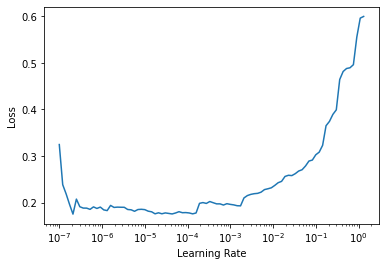

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.182552,0.175910,0.954866,0.913630,06:53
1,0.178311,0.176107,0.954369,0.912721,06:48
2,0.176345,0.175860,0.954574,0.913096,06:48


Better model found at epoch 0 with valid_loss value: 0.17591042816638947.


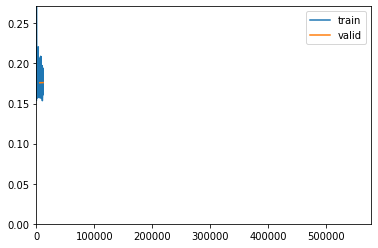

No improvement since epoch 0: early stopping


In [ ]:
name = "model_DeepLabV3Plus_resnet50_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17591042816638947,0.9548661108086268,0.9136304168142638]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16300122439861298,0.9583621969273147,0.9200532028506269]

Comparación de resultado buscado contra resultado obtenido.

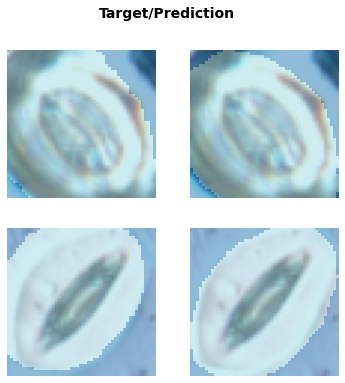

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.1579761505126953,0.9595948509428822,0.9223280486573224]

Comparación de resultado buscado contra resultado obtenido.

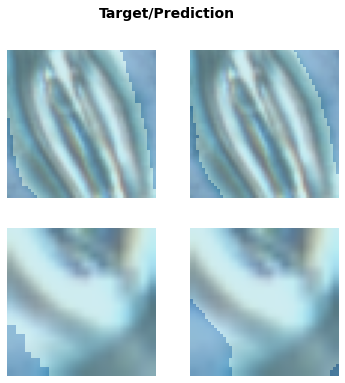

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.15935996174812317,0.9594464535303092,0.9220538979329267]

Comparación de resultado buscado contra resultado obtenido.

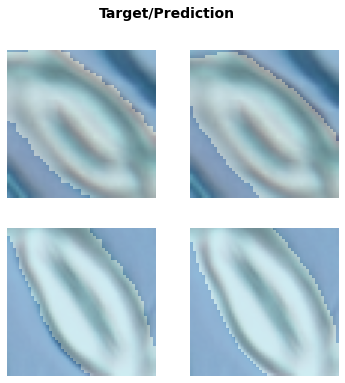

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.1532624512910843,0.9605956410202557,0.9241789614613072]

Comparación de resultado buscado contra resultado obtenido.

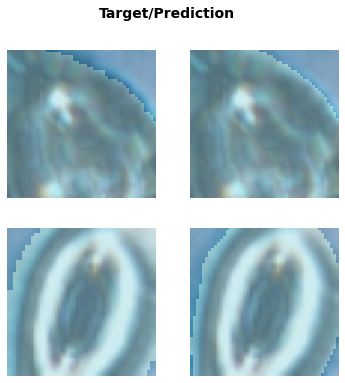

In [ ]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16197243332862854,0.9589184118730545,0.921079022824989]

Comparación de resultado buscado contra resultado obtenido.

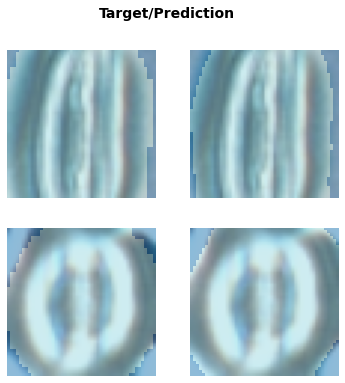

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.15875115990638733,0.9596426956813006,0.9224164541332686]

Comparación de resultado buscado contra resultado obtenido.

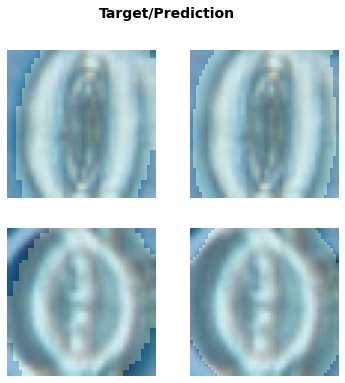

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16936002671718597,0.957609013135657,0.9186658607019216]

Comparación de resultado buscado contra resultado obtenido.

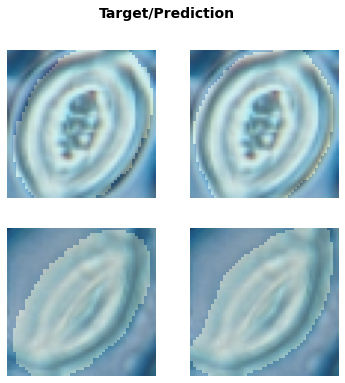

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_DeepLabV3Plus_resnet50_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.1599811166524887,0.9593567981929008,0.92188830573914]

Comparación de resultado buscado contra resultado obtenido.

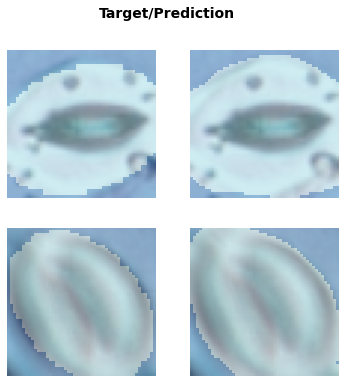

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [28]:
learn.load("model_DeepLabV3Plus_resnet50_da_wd1_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.15326257050037384,0.9605956410202557,0.9241789614613072]

In [31]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [33]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/DeepLabV3Plus/model_DeepLabV3Plus_resnet50.pkl")